In [1]:
from IPython.core.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os

print(os.getpid())
%cd ../

32379
/media/work/docs/codes/c++/QSVT_framework/simulations


In [2]:
import pylib.measurement as mse
import pylib.mix as mix
import waves_dielectrics.stationary_sim as sim

In [3]:
# --- Define the inversion function ---
F_inv  = lambda x, param, coef_norm: (coef_norm/param) * (1. / x)
F_Ying = lambda x, param, coef_norm: (coef_norm/param) * (1 - np.exp(-(5*param*x)**2)) / x

In [6]:
# -------------------------------------------------
# --- Input parameters ---
# -------------------------------------------------

kappa, eps, N_deg, N_deg_step, coef_norm = 20, 1e-8, 800, 100, 0.25

# kappa, eps, N_deg, N_deg_step, coef_norm = 200, 1e-6, 6501, 500, 0.25
# kappa, eps, N_deg, N_deg_step, coef_norm = 200, 1e-6, 6501, 500, 0.25

# kappa, eps, N_deg, N_deg_step, coef_norm = 500, 1e-8, 800, 100, 0.25

In [7]:
# ---------------------------------------------------
# --- Fourier series over the Chebyschev basis ---
# ---------------------------------------------------
err_res, counter_stage = 1, -1
while err_res > eps:
    counter_stage += 1
    print("STEP: {:d}, current N-deg: {:d}".format(counter_stage, N_deg))
    N_qu = 2*N_deg

    coefs = np.zeros(int(N_deg/2.), dtype=np.complex)
    counter_coef = -1
    for ii in range(N_deg):
        temp_val = 1. / N_qu
        if ii == 0:
            temp_val = 1. / (2 * N_qu)

        # --- for odd functions, calc. only 1-st, 3-rd etc. coefficients:
        if ii%2 == 1:
            counter_coef += 1
            coefs[counter_coef] = temp_val * (-1)**ii
            sum_temp = 0
            for kk in range(2*N_qu):
                th_kk = np.pi * kk / N_qu
                sum_temp = sum_temp + F_Ying(-np.cos(th_kk), kappa, coef_norm) * np.exp(1j * ii * th_kk)
            coefs[counter_coef] = coefs[counter_coef] * sum_temp 

    # compute the Fourier series:
    Nx_half = 101
    x = np.concatenate((np.linspace(-1., -1./kappa, Nx_half), np.linspace(1./kappa, 1., Nx_half)))
    ref_funct = 0
    for ii in range(1,len(coefs)+1):
        ref_funct += coefs[ii-1] * np.cos((2*ii-1) * np.arccos(x))

    # absolute error:
    err_res = np.max(np.abs(F_Ying(x, kappa, coef_norm) - np.real(ref_funct)))
    
    print("\t res error: {:0.3e}".format(err_res))
    if err_res > eps:
        N_deg += N_deg_step
        
print("\nresulting number of coefficients: {:d}".format(len(coefs)))
print("resulting absolute error: {:0.3e}".format(err_res))

del N_deg, N_deg_step, N_qu, counter_coef

STEP: 0, current N-deg: 800
	 res error: 2.677e-09

resulting number of coefficients: 400
resulting absolute error: 2.677e-09


<IPython.core.display.Javascript object>


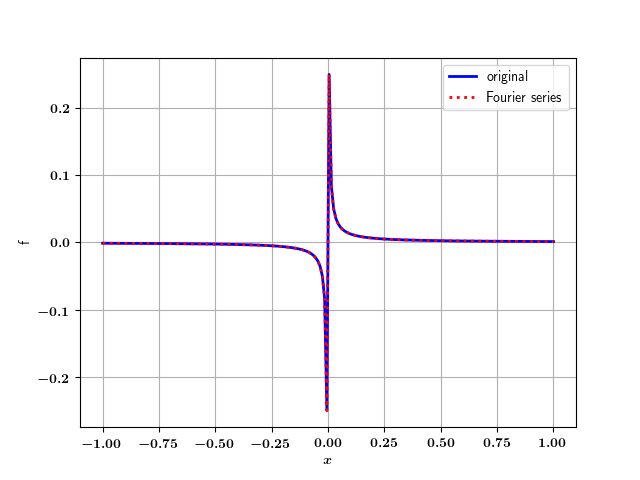

In [10]:
# -------------------------------------
# --- Plot the results ---
# -------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, F_Ying(x, kappa, coef_norm), color='b',  linewidth = 2, linestyle='-', label = "original")
ax.plot(x, np.real(ref_funct), color='r',  linewidth = 2, linestyle=':', label = "Fourier series")

plt.xlabel('$x$')
plt.ylabel("f")
ax.legend()
plt.grid(True)
plt.show()

In [11]:
# ------------------------------------------
# --- Store the results to the .mat file ---
# ------------------------------------------
from scipy.io import savemat

mdic = {
    "parity": 1,
    "coef": coefs
}

path_save = "/media/work/docs/codes/c++/QSVT_framework/simulations/QSVT-angles-matrix-inversion/Fourier-coefs/"

file_name = "coef_xodd_{:d}".format(int(kappa))
file_name += "_" + "{:d}".format(np.int(np.floor(-np.log10(err_res))))
file_name += ".mat"

full_name = path_save + file_name
savemat(full_name, mdic)

print("file name: ", full_name)

file name:  /media/work/docs/codes/c++/QSVT_framework/simulations/QSVT-angles-matrix-inversion/Fourier-coefs/coef_xodd_200_6.mat


In [5]:
# ------------------------------------------------------------
# --- Read polynomial coefficients from the .hdf5 file ---
# ------------------------------------------------------------
import h5py
path_root = "/media/work/docs/codes/c++/QSVT_framework/simulations/QSVT-angles-matrix-inversion/Fourier-coefs/"

# filename = path_root + "coef_xodd_20_3.hdf5";
# filename = path_root + "coef_xodd_50_9.hdf5";
# filename = path_root + "coef_xodd_1000_12.hdf5";
# filename = path_root + "coef_xodd_400_6.hdf5";
filename = path_root + "coef_xodd_500_5.hdf5";
# filename = path_root + "coef_xodd_600_10.hdf5";
# filename = path_root + "coef_xodd_700_11.hdf5";
# filename = path_root + "coef_xodd_800_10.hdf5";

with h5py.File(filename, "r") as f:
    gr = f["basic"]
    param = gr["param"][()]
    eps   = gr["eps"][()]
    factor_norm = gr["coef_norm"][()]
    sim_time = gr["date-of-simulation"][()].decode("utf-8")

    gr = f["coefs"]
    coefs_real = np.array(gr["real"])
    coefs_imag = np.array(gr["imag"])
    
    gr = f["functions"]
    x         = np.array(gr["x"])
    ref_funct = np.array(gr["pol"])
    orig_func = np.array(gr["orig"])
    
coefs = coefs_real + 1j * coefs_imag
Nx_half = int(len(x)/2)
x_half_neg = x[0:Nx_half]
x_half_pos = -x_half_neg


   
# # compute the Fourier series:
# Nx_half = 1001
# x_half_pos = np.linspace(1./param, 1., Nx_half)
# x_half_neg = np.linspace(-1., -1./param, Nx_half)
# x = np.concatenate((x_half_neg, x_half_pos))

# # to remove -> read from .hdf5
# ref_funct = 0
# for ii in range(1,len(coefs)+1):
#     ref_funct += coefs[ii-1] * np.cos((2*ii-1) * np.arccos(x))
    
# err_res = np.max(np.abs(F_Ying(x, param, factor_norm) - np.real(ref_funct)))

print("when simulated: ", sim_time)
print("condition number: {:f}".format(param))
print("absolute error: {:0.3e}".format(eps))
print("norm. factor: {:0.3e}".format(factor_norm))
print("number of coefficients: {:d}".format(len(coefs)))

del path_root, filename, f

when simulated:  08-22-2022 23:22:38
condition number: 500.000000
absolute error: 3.910e-06
norm. factor: 2.000e-02
number of coefficients: 6500


<IPython.core.display.Javascript object>


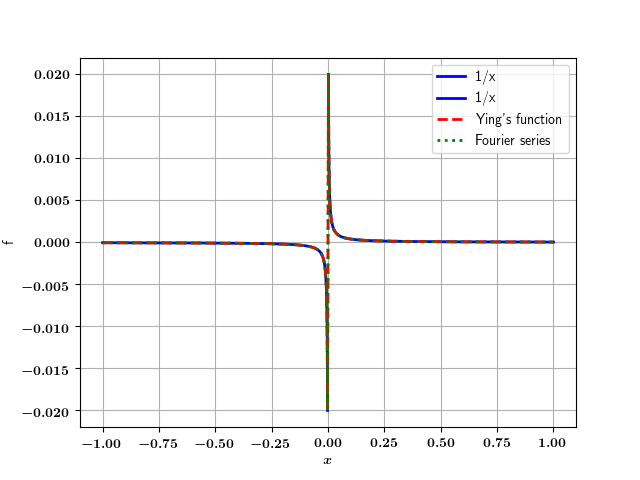

In [6]:
# -------------------------------------
# --- Plot the results ---
# -------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)

# ax.plot(x_half_pos, F_inv(x_half_pos, param, factor_norm), color='b',  linewidth = 2, linestyle='-', label = "1/x")
# ax.plot(x_half_neg, F_inv(x_half_neg, param, factor_norm), color='b',  linewidth = 2, linestyle='-', label = "1/x")
# ax.plot(x,   F_Ying(x, param, factor_norm), color='r',  linewidth = 2, linestyle='--', label = "Ying's function")
# ax.plot(x, np.real(ref_funct), color='g',  linewidth = 2, linestyle=':', label = "Fourier series")

ax.plot(x_half_pos, F_inv(x_half_pos, param, factor_norm), color='b',  linewidth = 2, linestyle='-', label = "1/x")
ax.plot(x_half_neg, F_inv(x_half_neg, param, factor_norm), color='b',  linewidth = 2, linestyle='-', label = "1/x")
ax.plot(x, orig_func, color='r',  linewidth = 2, linestyle='--', label = "Ying's function")
ax.plot(x, ref_funct, color='g',  linewidth = 2, linestyle=':', label = "Fourier series")

plt.xlabel('$x$')
plt.ylabel("f")
ax.legend()
plt.grid(True)
plt.show()

In [7]:
# ------------------------------------------
# --- Store the results to the .mat file ---
# ------------------------------------------
from scipy.io import savemat

mdic = {
    "parity": 1,
    "coef": coefs
}

path_save = "/media/work/docs/codes/c++/QSVT_framework/simulations/QSVT-angles-matrix-inversion/Fourier-coefs/"

file_name = "coef_xodd_{:d}".format(int(param))
file_name += "_" + "{:d}".format(np.int(np.round(-np.log10(eps))))
file_name += ".mat"

full_name = path_save + file_name
savemat(full_name, mdic)

print("file name: ", full_name)

file name:  /media/work/docs/codes/c++/QSVT_framework/simulations/QSVT-angles-matrix-inversion/Fourier-coefs/coef_xodd_500_5.mat


<IPython.core.display.Javascript object>


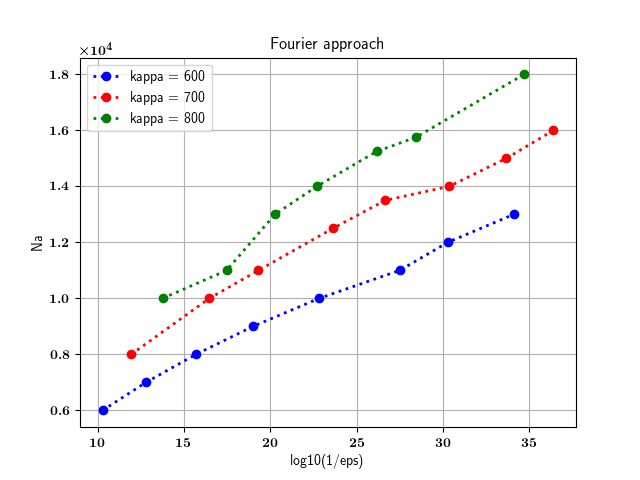

In [3]:
# -------------------------------------
# --- Fourier approach: scan ---
# -------------------------------------

# for kappa = 600
eps_array_600 = \
    np.array([8.109e-04, 1.417e-04, 1.906e-05, 1.917e-06, 1.349e-07, 5.273e-09, 7.676e-10, 5.411e-11])
Na_array_600  = \
    np.array([     6000,      7000,      8000,      9000,     10000,     11000,     12000,     13000])

# for kappa = 700
eps_array_700 = \
    np.array([2.562e-04, 1.110e-05, 1.544e-06, 7.754e-08, 9.442e-09, 7.202e-10,  7.288e-11, 1.096e-11])
Na_array_700  = \
    np.array([     8000,     10000,     11000,     12500,     13500,     14000,      15000,     16000])

# for kappa = 800
eps_array_800 = np.array([7.268e-05, 5.543e-06, 7.951e-07, 1.479e-07, 1.331e-08, 2.773e-09, 3.572e-11])
Na_array_800  = np.array([    10000,     11000,     13000,     14000,     15250,     15750,     18000])


log_inv_eps_600 = np.log2(1./eps_array_600)
log_inv_eps_700 = np.log2(1./eps_array_700)
log_inv_eps_800 = np.log2(1./eps_array_800)


fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(log_inv_eps_600, Na_array_600, 
        color='b', marker='o', linewidth = 2, linestyle=':', label = "kappa = 600")
ax.plot(log_inv_eps_700, Na_array_700, 
        color='r', marker='o', linewidth = 2, linestyle=':', label = "kappa = 700")
ax.plot(log_inv_eps_800, Na_array_800, 
        color='g', marker='o', linewidth = 2, linestyle=':', label = "kappa = 800")

plt.xlabel('log10(1/eps)')
plt.ylabel("Na")
ax.legend()
plt.grid(True)
plt.show()
plt.title("Fourier approach")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

del eps_array_600, Na_array_600, log_inv_eps_600
del eps_array_700, Na_array_700, log_inv_eps_700
del eps_array_800, Na_array_800, log_inv_eps_800

In [28]:
Nx_half = 101
Nx_full = 201
kappa = 100
eps = 1e-12

x_half = np.linspace(1./kappa, 1., Nx_half)
x_full = np.linspace(-1, 1., Nx_full)
x = np.concatenate((np.linspace(-1., -1./kappa, Nx_half), np.linspace(1./kappa, 1., Nx_half)))

b_Dong = np.ceil(kappa**2 * np.log10(kappa/eps))

f_ref = 1. / x_half
f_ref = f_ref / np.max(f_ref)

f_Dong_35 = (1 - (1 - x**2)**b_Dong) / x
f_Dong_35 = f_Dong_35 / np.max(np.abs(f_Dong_35))

f_Ying = (1 - np.exp(-(5*kappa*x)**2)) / x
f_Ying = f_Ying / np.max(np.abs(f_Ying))

<IPython.core.display.Javascript object>


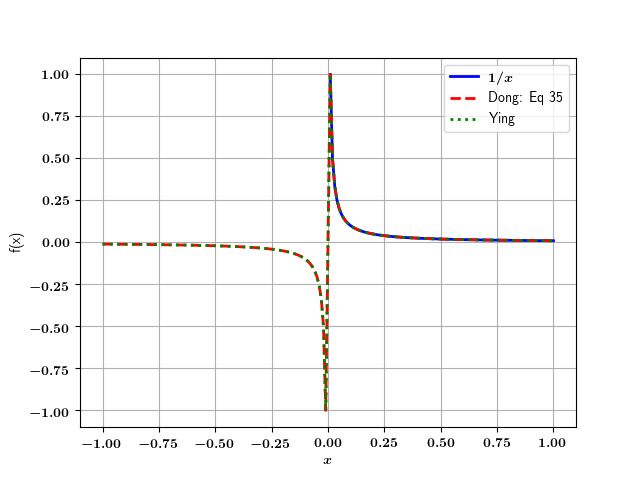

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_half, f_ref,     color='b',  linewidth = 2, linestyle='-', label = "$1/x$")
ax.plot(x,      f_Dong_35, color='r',  linewidth = 2, linestyle='--', label = "Dong: Eq 35")
ax.plot(x,      f_Ying,    color='g',  linewidth = 2, linestyle=':', label = "Ying")

plt.xlabel('$x$')
plt.ylabel("f(x)")
ax.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


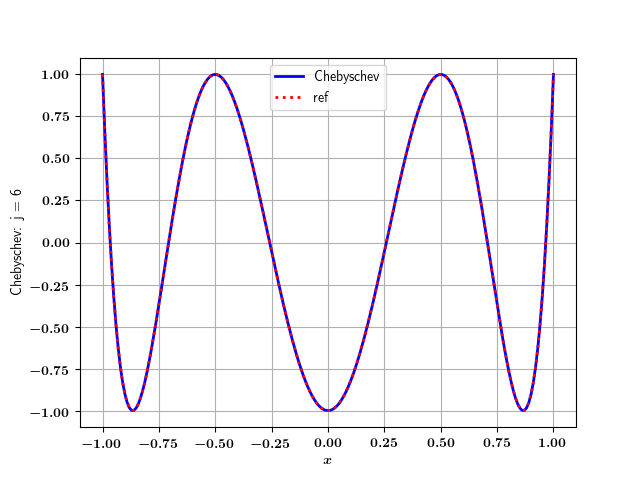

In [39]:
# -----------------------------------------------------
# --- Chebyschev functions ---
# -----------------------------------------------------
jj_order = 6

T_ch = np.cos(jj_order * np.arccos(x))

T_ref = []
T_ref.append(np.ones(len(x)))
T_ref.append(x)
for ii in range(2, jj_order+1):
    T_ref.append( 2*x*T_ref[-1] - T_ref[-2] )

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, T_ch,      color='b',  linewidth = 2, linestyle='-', label = "Chebyschev")
ax.plot(x, T_ref[-1], color='r',  linewidth = 2, linestyle=':', label = "ref")

plt.xlabel('$x$')
plt.ylabel("Chebyschev: j = {:d}".format(jj_order))
ax.legend()
plt.grid(True)
plt.show()

In [14]:
# ---------------------------------------------------
# --- OLD VERSION: Fourier series over the Chebyschev basis ---
# ---------------------------------------------------
kappa = 20
Nx_half = 101
eps = 1e-12
x = np.concatenate((np.linspace(-1., -1./kappa, Nx_half), np.linspace(1./kappa, 1., Nx_half)))

F_Ying = lambda x: (1./(4.*kappa)) * (1 - np.exp(-(5*kappa*x)**2)) / x

N_deg = 901  # d + 1
N_qu = 2*N_deg

coefs = np.zeros(N_deg, dtype=np.complex)
for ii in range(N_deg):
    temp_val = 1. / N_qu
    if ii == 0:
        temp_val = 1. / (2 * N_qu)
    
    coefs[ii] = temp_val * (-1)**ii
    sum_temp = 0
    for kk in range(2*N_qu):
        th_kk = np.pi * kk / N_qu
        sum_temp = sum_temp + F_Ying(-np.cos(th_kk)) * np.exp(1j * ii * th_kk)
    coefs[ii] = coefs[ii] * sum_temp    

In [15]:
# -----------------------------------------------------
# --- OLD VERSION: For odd function: remove 0-th, 2-nd etc coefs ---
# -----------------------------------------------------
coefs_new = np.zeros(int(N_deg/2.), dtype=np.complex)
count_el = -1
for ii in range(N_deg):
    if ii%2 == 1:
        count_el += 1
        coefs_new[count_el] = coefs[ii]

<IPython.core.display.Javascript object>


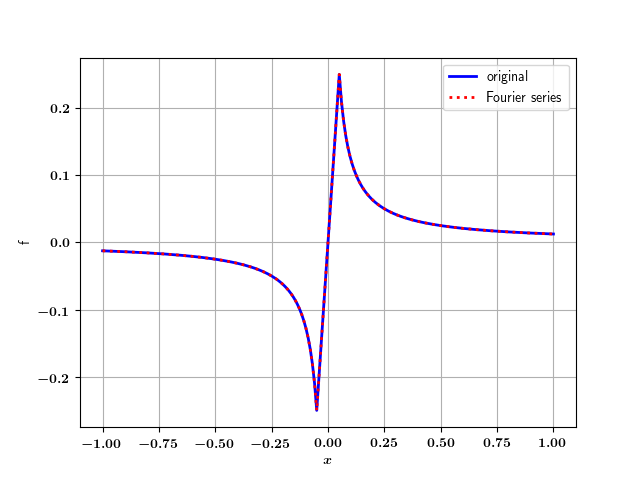

In [17]:
# -------------------------------------
# --- OLD VERSION: Plot the results ---
# -------------------------------------
ref_funct = 0
for ii in range(1,len(coefs_new)+1):
    ref_funct += coefs_new[ii-1] * np.cos((2*ii-1) * np.arccos(x))

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, F_Ying(x), color='b',  linewidth = 2, linestyle='-', label = "original")
ax.plot(x, np.real(ref_funct), color='r',  linewidth = 2, linestyle=':', label = "Fourier series")

plt.xlabel('$x$')
plt.ylabel("f")
ax.legend()
plt.grid(True)
plt.show()

In [18]:
# ------------------------------------------
# --- OLD VERSION: Store the results to the .mat file ---
# ------------------------------------------
from scipy.io import savemat

mdic = {
    "parity": 1,
    "coef": coefs_new
}

path_save = "./qsvt-test-polynomials/"

file_name = "coef_xodd_{:d}".format(int(kappa))
file_name += "_" + "{:d}".format(np.int(np.ceil(-np.log10(eps))))
file_name += ".mat"

full_name = path_save + file_name
savemat(full_name, mdic)

print("file name: ", full_name)

file name:  ./qsvt-test-polynomials/coef_xodd_20_12.mat
